In [1]:
import tensorflow as tf
# from tensorboard.plugins.hparams import api as hp
from tensorflow import keras

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
ratings = pd.read_pickle("./Data/reviews_20_1000_longform.pkl")

In [6]:
ratings.shape

(8854093, 3)

In [7]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings['user_id'].values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = item_enc.fit_transform(ratings['movie_id'].values)
n_movies = ratings['movie'].nunique()

nmovie_id = ratings.movie_id.nunique()
nuser_id = ratings.user_id.nunique()

n_users, n_movies

(64815, 89418)

In [8]:
X_train, X_test = train_test_split(ratings[['movie', 'user', 'rating_score']], test_size=0.3, random_state=42)

In [9]:
X_train.shape, X_test.shape

((6197865, 3), (2656228, 3))

In [10]:
def train_test_model(output_bias):
    
    input_movies = keras.layers.Input(shape=[1])
    embed_movies = keras.layers.Embedding(nmovie_id+1, 15)(input_movies)
    movies_out = keras.layers.Flatten()(embed_movies)

    input_users = keras.layers.Input(shape=[1])
    embed_users = keras.layers.Embedding(nuser_id+1, 15)(input_users)
    users_out = keras.layers.Flatten()(embed_users)

    bias = keras.initializers.Constant(output_bias)
    
    conc_layer = keras.layers.Concatenate()([movies_out, users_out])
    
    dense1 = keras.layers.Dense(128,activation='relu', kernel_regularizer='l2')(conc_layer)
    
    dropout1 = keras.layers.Dropout(rate=.6, seed=42)(dense1)
    
    dense2 = keras.layers.Dense(64,activation='relu', kernel_regularizer='l2')(dropout1)
    
    dropout2 = keras.layers.Dropout(rate=.5, seed=42)(dense2)
    
    dense3 = keras.layers.Dense(32, activation='relu', kernel_regularizer='l2')(dropout2)
    
    dropout3 = keras.layers.Dropout(rate=.4, seed=42)(dense3)
    
    dense4 = keras.layers.Dense(16, activation='relu', kernel_regularizer='l2')(dropout3)
    
    x_out = keras.layers.Dense(1, activation='relu', kernel_regularizer='l2', bias_initializer=bias)(dense3)

    model = keras.Model([input_movies, input_users], x_out)
    
    opt = tf.optimizers.Adam(learning_rate=.01)
    model.compile(optimizer=opt, loss='mean_squared_error', metrics = keras.metrics.RootMeanSquaredError())


#     print(hist.history['val_mean_squared_error'])
    return model

In [11]:
callback = keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                        min_delta=.001,
                                        patience=30,
                                        mode="auto",
                                        restore_best_weights=True)

In [13]:
model = train_test_model(output_bias=0)

In [14]:
output = model.fit([X_train.movie, X_train.user], 
             X_train.rating_score,  
             batch_size=len(X_train), epochs=100, validation_split=.2,
                  callbacks=[callback])

Epoch 1/100
1/1 [==============================] - 14s 14s/step - loss: 16.6554 - root_mean_squared_error: 3.8570 - val_loss: 15.3073 - val_root_mean_squared_error: 3.7066
Epoch 2/100
1/1 [==============================] - 9s 9s/step - loss: 15.3034 - root_mean_squared_error: 3.7060 - val_loss: 13.4078 - val_root_mean_squared_error: 3.4624
Epoch 3/100
1/1 [==============================] - 9s 9s/step - loss: 13.3891 - root_mean_squared_error: 3.4597 - val_loss: 10.4492 - val_root_mean_squared_error: 3.0232
Epoch 4/100
1/1 [==============================] - 8s 8s/step - loss: 10.4294 - root_mean_squared_error: 3.0200 - val_loss: 6.3526 - val_root_mean_squared_error: 2.2628
Epoch 5/100
1/1 [==============================] - 8s 8s/step - loss: 6.4259 - root_mean_squared_error: 2.2790 - val_loss: 2.6175 - val_root_mean_squared_error: 1.1975
Epoch 6/100
1/1 [==============================] - 8s 8s/step - loss: 3.1545 - root_mean_squared_error: 1.4039 - val_loss: 5.2403 - val_root_mean_squar

1/1 [==============================] - 9s 9s/step - loss: 1.4698 - root_mean_squared_error: 1.0327 - val_loss: 1.1249 - val_root_mean_squared_error: 0.8542
Epoch 50/100
1/1 [==============================] - 9s 9s/step - loss: 1.4420 - root_mean_squared_error: 1.0231 - val_loss: 1.1432 - val_root_mean_squared_error: 0.8694
Epoch 51/100
1/1 [==============================] - 9s 9s/step - loss: 1.4289 - root_mean_squared_error: 1.0206 - val_loss: 1.1633 - val_root_mean_squared_error: 0.8851
Epoch 52/100
1/1 [==============================] - 9s 9s/step - loss: 1.4242 - root_mean_squared_error: 1.0219 - val_loss: 1.1701 - val_root_mean_squared_error: 0.8927
Epoch 53/100
1/1 [==============================] - 8s 8s/step - loss: 1.4179 - root_mean_squared_error: 1.0221 - val_loss: 1.1563 - val_root_mean_squared_error: 0.8884
Epoch 54/100
1/1 [==============================] - 9s 9s/step - loss: 1.4008 - root_mean_squared_error: 1.0167 - val_loss: 1.1271 - val_root_mean_squared_error: 0.8749

In [120]:
callback.best

0.8430203199386597

In [121]:
callback.monitor

'val_root_mean_squared_error'

In [122]:
callback.model

In [30]:
model.save('saved_model/copy16/model.h5')

In [ ]:
output2 = model.fit([X_train.movie, X_train.user], 
             X_train.rating_score,  
             batch_size=len(X_train), epochs=10, validation_split=.2,
                  callbacks=[callback])

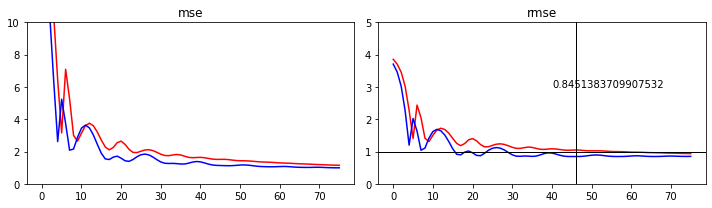

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 3))


axs[0].plot(output.history['loss'], color='r')
axs[0].plot(output.history['val_loss'], color='b')

axs[1].plot(output.history['root_mean_squared_error'], color='r')
axs[1].plot(output.history['val_root_mean_squared_error'], color='b')
axs[1].axvline(np.where(output.history['val_root_mean_squared_error']==np.min(output.history['val_root_mean_squared_error'])), 
                 color='k', lw=1)
axs[1].annotate(str(np.min(output.history['val_root_mean_squared_error'])),
                    xy=(40,3),)

#     title_str = '-'.join(str(run_history[key]['params'][param]) for param in run_history[key]['params'].keys(),
#                         xytext=(.8,.8), xycoords='subfigure fraction')

axs[0].set_title("mse")
axs[1].set_title("rmse")

axs[0].set_ylim(0,10)
axs[1].set_ylim(0,5)

axs[1].axhline(1, color='k', lw=1)
    
plt.tight_layout()   
plt.show()

In [90]:
len(output.history['loss'])

100

In [91]:
model.trainable_variables

[<tf.Variable 'embedding_14/embeddings:0' shape=(89419, 15) dtype=float32, numpy=
 array([[-0.04060972, -0.0408831 , -0.07540319, ...,  0.05272159,
         -0.01610826,  0.03636319],
        [-0.07631765,  0.01794105, -0.00635751, ..., -0.0513144 ,
         -0.06476335, -0.01258612],
        [-0.02940135, -0.03517935, -0.00887026, ...,  0.12255664,
          0.15908323,  0.02870064],
        ...,
        [ 0.02127912,  0.04027199,  0.00054735, ..., -0.1885152 ,
         -0.03283613, -0.06176513],
        [ 0.01619839,  0.04960533,  0.02113556, ...,  0.09155231,
          0.01556375,  0.04586617],
        [ 0.01719183,  0.03272376, -0.01236945, ...,  0.01487299,
         -0.04141879,  0.04155825]], dtype=float32)>,
 <tf.Variable 'embedding_15/embeddings:0' shape=(64816, 15) dtype=float32, numpy=
 array([[-0.07097471, -0.10677434, -0.12696075, ..., -0.08312505,
         -0.07205073, -0.0492179 ],
        [ 0.0753029 , -0.00496834, -0.00133236, ...,  0.05152988,
          0.0306449 , -0.

In [92]:
!mkdir -p saved_model
model.save('saved_model/rmse_845')

INFO:tensorflow:Assets written to: saved_model/rmse_845/assets


In [93]:
model.save('saved_model/rmse_845/model.h5')

In [94]:
X_train.groupby('rating_score').count()

,movie,user
rating_score,,
1,223618,223618
2,562898,562898
3,1558336,1558336
4,2254707,2254707
5,1598298,1598298


In [28]:
import random
from itertools import chain
def flatten(list_of_lists):
    "Flatten one level of nesting"
    return chain.from_iterable(list_of_lists)

In [95]:
to_drop = []
for rating in [3,4,5]:
    temp_df = X_train[X_train.rating_score==rating]
    to_drop.append(random.choices(temp_df.index, k=int(len(temp_df)*.95)))
    
to_drop = list(flatten(to_drop))

In [96]:
X_train_reduced = X_train.drop(index=to_drop)

In [97]:
X_train.shape, X_train_reduced.shape

((6197857, 3), (2879395, 3))

In [99]:
output_reduced = model.fit([X_train_reduced.movie, X_train_reduced.user], 
                             X_train_reduced.rating_score,  
                             batch_size=len(X_train_reduced), epochs=100, validation_split=.2,
                          callbacks=[callback])

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 1.2243 - root_mean_squared_error: 1.0039 - val_loss: 1.1510 - val_root_mean_squared_error: 0.9668
Epoch 2/100
1/1 [==============================] - 5s 5s/step - loss: 1.2104 - root_mean_squared_error: 0.9970 - val_loss: 1.1557 - val_root_mean_squared_error: 0.9691
Epoch 3/100
1/1 [==============================] - 4s 4s/step - loss: 1.2095 - root_mean_squared_error: 0.9965 - val_loss: 1.1403 - val_root_mean_squared_error: 0.9610
Epoch 4/100
1/1 [==============================] - 5s 5s/step - loss: 1.1970 - root_mean_squared_error: 0.9901 - val_loss: 1.1135 - val_root_mean_squared_error: 0.9468
Epoch 5/100
1/1 [==============================] - 4s 4s/step - loss: 1.1779 - root_mean_squared_error: 0.9802 - val_loss: 1.0990 - val_root_mean_squared_error: 0.9389
Epoch 6/100
1/1 [==============================] - 4s 4s/step - loss: 1.1725 - root_mean_squared_error: 0.9772 - val_loss: 1.1004 - val_root_mean_squared_error:

In [16]:
X_train

,movie,user,rating_score
11862877,91,8097,4
6424992,12048,44363,3
12709205,176,21194,4
8348272,28179,7508,3
5786658,9053,3915,3
...,...,...,...
13103465,212,52317,4
3382914,3297,11310,5
7663495,20601,24438,4
12216666,136,24176,4


In [17]:
X_train.groupby('user').count().sort_values(by='movie',ascending=False).head()

,movie,rating_score
user,,
49758,735,735
46967,734,734
14547,722,722
40854,719,719
20490,718,718


In [18]:
user = 58315
ratings[ratings.user==user]

,movie_id,rating_score,user_id,user,movie
13381,1085,4,89904558,58315,1038
19800,1094,4,89904558,58315,1047
23850,1099,2,89904558,58315,1052
35843,1103,5,89904558,58315,1056
48584,1116,3,89904558,58315,1069
...,...,...,...,...,...
15428890,981,2,89904558,58315,941
15489675,1046,3,89904558,58315,1002
15493413,1047,2,89904558,58315,1003
15498925,1049,2,89904558,58315,1005


In [19]:
movie_array = ratings[ratings.user==user].movie.values.astype(int)
user_array = np.array([int(user) for n in range(len(movie_array))])

In [20]:
pred = model.predict([movie_array, user_array])

In [21]:
def is_close_enough(pred, ratings):
    val = []
    for pair in zip(pred, ratings):
        if pair[1] == 5:
            val.append(pair[1] - 1 <= pair[0])
        else:
            val.append(pair[1] - .5 <= pair[0] <= pair[1] + .5)
        
    return val

In [22]:
val = is_close_enough(np.round(pred.flatten(), 1), ratings[ratings.user==user].rating_score.values)

In [23]:
sum(val) / len(pred.flatten())

0.5250501002004008

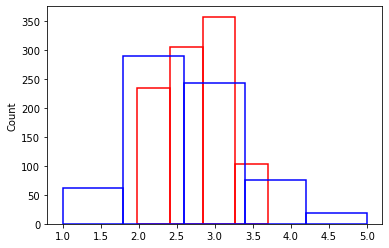

In [24]:
sns.histplot(pred.flatten(), bins=4, color='red', fill=False)
sns.histplot(X_train[X_train.user==user].rating_score.values, bins=5, color='blue', fill=False)

plt.show()

In [25]:
top_20_users = X_train.groupby('user').count().sort_values(by='movie',ascending=False).head(20).index

In [26]:
predictions = []

for user in top_20_users:
    movie_array = X_train[X_train.user==user].movie.values.astype(int)
    user_array = np.array([int(user) for n in range(len(movie_array))])
    pred = model.predict([movie_array, user_array])
    val = is_close_enough(np.round(pred.flatten(), 1), ratings[ratings.user==user].rating_score.values)
    
    predictions.append(list(pred.flatten()))
    print(user, sum(val) / len(pred.flatten()))

49758 0.3986394557823129
46967 0.3801089918256131
14547 0.40166204986149584
40854 0.44089012517385257
20490 0.3245125348189415
13686 0.44490934449093444
18058 0.3486750348675035
28524 0.4783216783216783
38238 0.37780898876404495
13828 0.3693820224719101
41054 0.4022503516174402
1380 0.3765867418899859
55147 0.3305084745762712
10210 0.4087694483734088
5321 0.3521923620933522
14125 0.4518413597733711
6497 0.3640226628895184
17796 0.4178470254957507
59336 0.42127659574468085
2488 0.5724431818181818


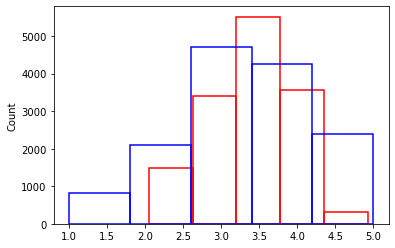

In [29]:
sns.histplot(list(flatten(predictions)), bins=5, color='red', fill=False)
sns.histplot(X_train[X_train.user.isin(top_20_users)].rating_score.values, bins=5, color='blue', fill=False)

plt.show()